In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn

In [2]:
save_file_name = os.path.join("..", "data", "temp_spam_data.csv")

if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            text_data.append(row)
else:
    zip_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read("SMSSpamCollection")
    text_data = file.decode()
    text_data = text_data.encode("ascii", errors="ignore")
    text_data = text_data.decode().split("\n")
    text_data = [x.split("\t") for x in text_data if len(x) >= 1]
    
    with open(save_file_name, "w") as f:
        writer = csv.writer(f)
        writer.writerows(text_data)
        
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]
target = [1 if x == "spam" else 0 for x in target]

In [3]:
texts = [x.lower() for x in texts]
texts = ["".join(c for c in x if c not in string.punctuation) for x in texts]
texts = ["".join(c for c in x if c not in "0123456789") for x in texts]
texts = [" ".join(x.split()) for x in texts]

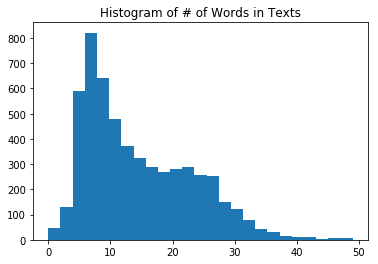

In [4]:
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 50]
plt.hist(text_lengths, bins=25)
plt.title("Histogram of # of Words in Texts")
plt.show()

In [6]:
sentence_size = 25
min_word_freq = 3
vocab_processor = learn.preprocessing.VocabularyProcessor(
    sentence_size, min_frequency=min_word_freq)
vocab_processor.fit_transform(texts)
embedding_size = len(vocab_processor.vocabulary_)

In [7]:
train_indices = np.random.choice(len(texts), round(len(texts) * 0.8), replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

In [17]:
with tf.Session() as sess:
    identity_mat = tf.diag(tf.ones(shape=[embedding_size]))
    A = tf.Variable(tf.random_normal(shape=[embedding_size, 1]))
    b = tf.Variable(tf.random_normal(shape=[1, 1]))
    x_data = tf.placeholder(shape=[sentence_size], dtype=tf.int32)
    y_target = tf.placeholder(shape=[1, 1], dtype=tf.float32)
    x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
    x_col_sums = tf.reduce_sum(x_embed, 0)
    x_col_sums_2D = tf.expand_dims(x_col_sums, 0)
    model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)
    
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=model_output,
        labels=y_target
    ))
    prediction = tf.sigmoid(model_output)
    
    my_opt = tf.train.GradientDescentOptimizer(0.001)
    train_step = my_opt.minimize(loss)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    loss_vec = []
    train_acc_all = []
    train_acc_avg = []
    for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
        y_data = [[target_train[ix]]]
        sess.run(train_step, feed_dict={x_data: t, y_target: y_data})
        
        temp_loss = sess.run(loss, feed_dict={x_data: t, y_target: y_data})
        loss_vec.append(temp_loss)
        
        if (ix + 1) % 10 == 0:
            print('Training Observation #' + str(ix + 1) + ': Loss = ' + str(temp_loss))
        
        [[temp_pred]] = sess.run(prediction, feed_dict={x_data: t, y_target: y_data})
        
        train_acc_temp = target_train[ix] == np.round(temp_pred)
        train_acc_all.append(train_acc_temp)
        if len(train_acc_all) >= 50:
            train_acc_avg.append(np.mean(train_acc_all[-50:]))
    
    test_acc_all = []
    for ix, t in enumerate(vocab_processor.fit_transform(texts_test)):
        y_data = [[target_test[ix]]]
        sess.run(train_step, feed_dict={x_data: t, y_target: y_data})
        
        if (ix + 1) % 50 == 0:
            print('Test Observation #' + str(ix + 1))
        
        [[temp_pred]] = sess.run(prediction, feed_dict={x_data: t, y_target: y_data})
        
        test_acc_temp = target_test[ix] == np.round(temp_pred)
        test_acc_all.append(test_acc_temp)

    print('overall Test Accuracy: {}'.format(np.mean(test_acc_all)))

Training Observation #10: Loss = 17.34446
Training Observation #20: Loss = 0.003193958
Training Observation #30: Loss = 8.025453
Training Observation #40: Loss = 6.6635866
Training Observation #50: Loss = 5.7880077
Training Observation #60: Loss = 5.513802
Training Observation #70: Loss = 0.09874808
Training Observation #80: Loss = 6.58816
Training Observation #90: Loss = 0.13252527
Training Observation #100: Loss = 0.6846022
Training Observation #110: Loss = 0.030152822
Training Observation #120: Loss = 3.5338133e-05
Training Observation #130: Loss = 0.013697386
Training Observation #140: Loss = 0.06408716
Training Observation #150: Loss = 0.003058608
Training Observation #160: Loss = 0.16892466
Training Observation #170: Loss = 0.4893214
Training Observation #180: Loss = 0.0040669776
Training Observation #190: Loss = 3.269542
Training Observation #200: Loss = 1.0105908
Training Observation #210: Loss = 0.009572016
Training Observation #220: Loss = 5.3245807
Training Observation #230: